## Factors impacting an NBA players 2023-2024 guaranteed contract value analysis notebook.
**What data are we exploring?**<br>
I am interested in sports analytics, and my favorite sport is basketball, so I used player performance stats from the last 5 NBA seasons. I wrote custom functions that leverage player names and IDs to pull stats from the NBA_API. After executing the functions and merging the returned dataframes, we have a dataset that contains 476 rows and 21 columns. The columns represent standard NBA performance metrics such as:
- total points
- total steals
- total assists
- etc.<br>

This notebook aims to inform players and their management firms if or how player performance impacts contract value and focus on visualization and analysis. ***The data collection and pre-processing was completed in a separate notebook to maintain clarity as you follow along.***


### 1. Import libraries required for the analysis

Below is a list of libraries used to analyze and visualize the data.

In [1]:
import math
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook+pdf"
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import sys
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\toobr\AppData\Local\Temp\ipykernel_20272\3289393469.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1. Load Data For Exploratory Analysis

In [2]:
#read in pre-processed file and view sample
preprocessed_data = pd.read_csv('../data/nba_regression_analysis_df.csv')
preprocessed_data.head()

,Current_Contract,First_Name,Last_Name,PLAYER_ID,GP,GS,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
0,51915615.0,stephen,curry,201939,257,257,8774.0,2417,5144,1261,3049,1183,1287,151,1265,1513,311,78,806,543,7278
1,47649433.0,kevin,durant,201142,184,181,6548.0,1868,3442,386,949,1196,1315,76,1204,1016,141,231,623,381,5318
2,47607350.0,nikola,jokic,203999,368,368,12126.0,3323,5903,409,1199,1597,1930,972,3220,2953,484,257,1224,1007,8652
3,47607350.0,joel,embiid,203954,300,300,9825.0,2817,5561,353,1040,2659,3206,673,2796,1089,284,467,984,894,8646
4,47607350.0,lebron,james,2544,278,277,9795.0,2872,5661,645,1862,1225,1717,280,1972,2212,321,185,1000,491,7614


The purpose of exploratory analysis is to understand the properties of the data, discover patterns, and determine is there are additional data quality issues that need to be addressed.


In [3]:
#confirm datatypes
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Current_Contract  419 non-null    float64
 1   First_Name        419 non-null    object 
 2   Last_Name         419 non-null    object 
 3   PLAYER_ID         419 non-null    int64  
 4   GP                419 non-null    int64  
 5   GS                419 non-null    int64  
 6   MIN               419 non-null    float64
 7   FGM               419 non-null    int64  
 8   FGA               419 non-null    int64  
 9   FG3M              419 non-null    int64  
 10  FG3A              419 non-null    int64  
 11  FTM               419 non-null    int64  
 12  FTA               419 non-null    int64  
 13  OREB              419 non-null    int64  
 14  DREB              419 non-null    int64  
 15  AST               419 non-null    int64  
 16  STL               419 non-null    int64  
 1

In [4]:
#convert Player ID to string 
preprocessed_data['PLAYER_ID'] = preprocessed_data['PLAYER_ID'].astype(str)

In [5]:
#review the summary statisitcs
preprocessed_data.describe().round()

,Current_Contract,GP,GS,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
count,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0,419.0
mean,11052897.0,198.0,112.0,4929.0,876.0,1859.0,254.0,700.0,383.0,490.0,209.0,701.0,536.0,155.0,100.0,283.0,396.0,2390.0
std,11670322.0,94.0,105.0,3235.0,735.0,1539.0,253.0,664.0,428.0,530.0,209.0,588.0,572.0,118.0,108.0,255.0,249.0,2048.0
min,92857.0,10.0,0.0,62.0,7.0,19.0,0.0,0.0,0.0,0.0,1.0,9.0,4.0,0.0,0.0,2.0,8.0,21.0
25%,2368860.0,123.0,20.0,2127.0,319.0,683.0,46.0,150.0,98.0,136.0,72.0,262.0,135.0,56.0,32.0,98.0,184.0,830.0
50%,6175000.0,206.0,72.0,4634.0,684.0,1428.0,163.0,486.0,246.0,322.0,145.0,571.0,341.0,136.0,63.0,213.0,375.0,1808.0
75%,15552322.0,273.0,199.0,7444.0,1236.0,2788.0,426.0,1154.0,524.0,646.0,266.0,958.0,726.0,220.0,135.0,390.0,572.0,3424.0
max,51915615.0,377.0,368.0,12485.0,3428.0,6741.0,1261.0,3049.0,2659.0,3434.0,1374.0,3448.0,3285.0,559.0,748.0,1461.0,1087.0,9529.0


I'm curious about the following and will use visualizations to dig deeper:
- How many games have the top earners played?
- How does the number of games played relate to contract values?
- How does the number of games started relate to contract values?

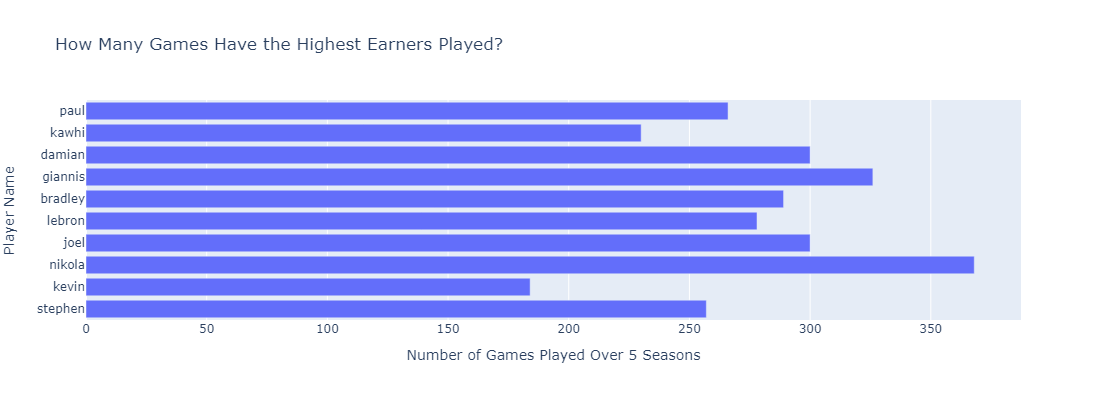

In [6]:
#create a dataframe of top 5 highest earners
top_earners = preprocessed_data.nlargest(10, 'Current_Contract').sort_values('Current_Contract', ascending= False)

# Create a horizontal bar chart
fig = px.bar(top_earners, x='GP', y='First_Name', orientation='h',
             title='How Many Games Have the Highest Earners Played?', 
             labels={'GP': 'Number of Games Played Over 5 Seasons', 
                     'First_Name': 'Player Name'})

# Update layout
fig.update_layout(width=800, height=400, 
                  xaxis_title='Number of Games Played Over 5 Seasons', 
                  yaxis_title='Player Name')

# Show the plot
fig.show()

With the exception of Kevin Durant and Kawhi Leonard the top earners have all played at least 3 seasons over the last five years. Next I will explore the relationship between the number of games played and contract values.

                        GP  Current_Contract
GP                1.000000          0.566553
Current_Contract  0.566553          1.000000


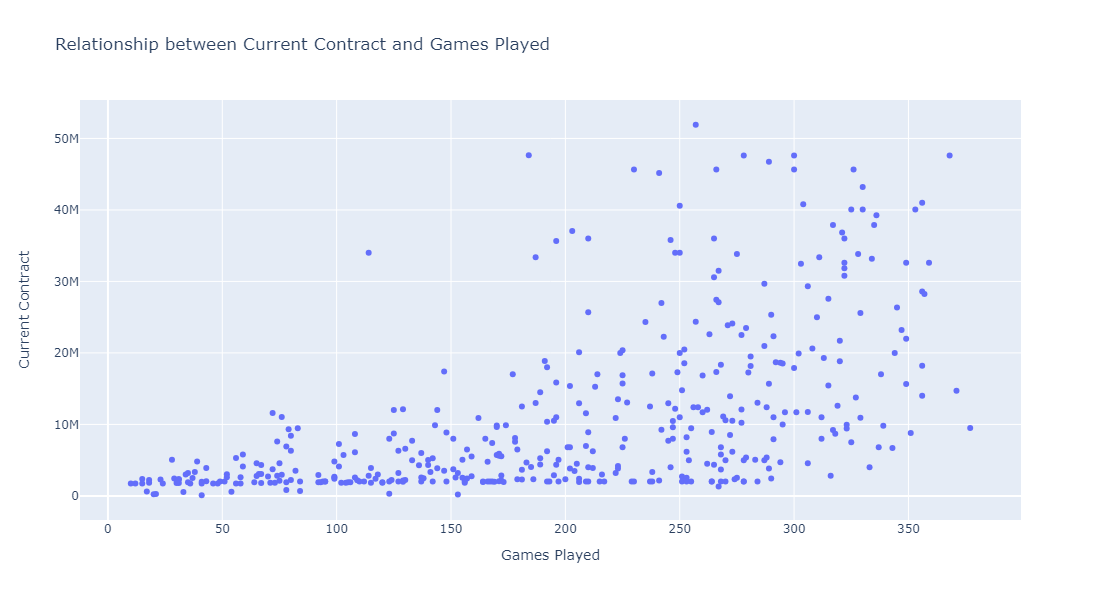

In [7]:
#print the correlation metric
print(preprocessed_data[['GP','Current_Contract']].corr())

# Create scatter plot
fig = px.scatter(preprocessed_data, x='GP', y='Current_Contract',
                 title='Relationship between Current Contract and Games Played',
                 labels={'GP': 'Games Played', 'Current_Contract': 'Current Contract'})

# Update layout
fig.update_layout(width=800, height=600)

# Show the plot
fig.show()

The scatterplot and correlation value tells me that there isn't strong relationship between games played and contract values. In fact the scatter plot shows the a majority of players making less than $10 million this year. This makes sense in the context of the data because NBA teams usually have 12-man rosters but will only play 7-8 guys. Let's see if Games started has a strong relationship to contract values.

                        GS  Current_Contract
GS                1.000000          0.781069
Current_Contract  0.781069          1.000000


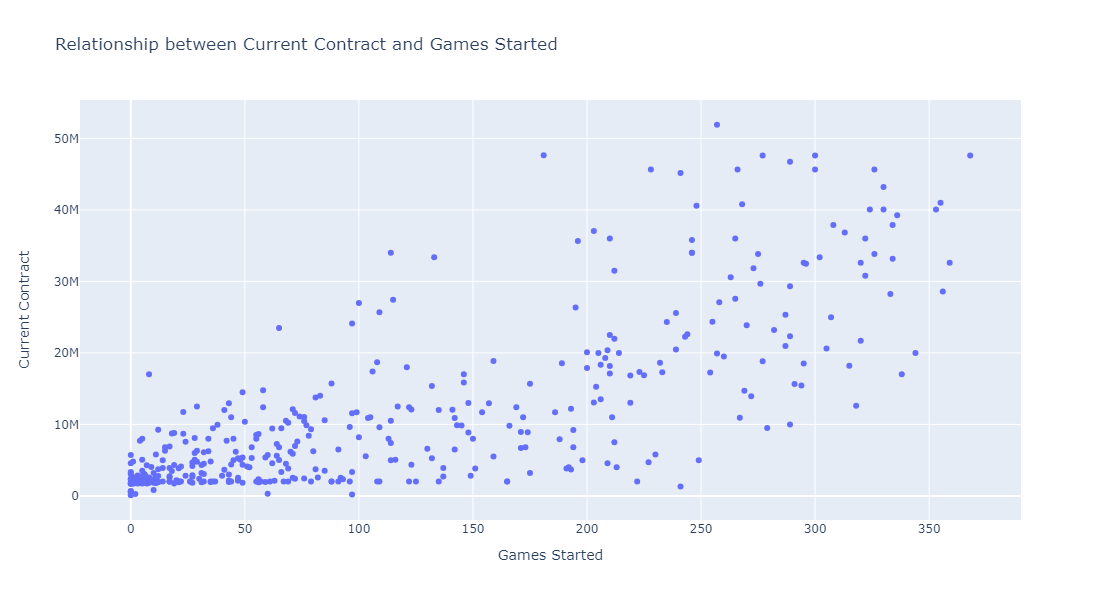

In [8]:
#print the correlation metric
print(preprocessed_data[['GS','Current_Contract']].corr())

# Create scatter plot
fig = px.scatter(preprocessed_data, x='GS', y='Current_Contract',
                 title='Relationship between Current Contract and Games Started',
                 labels={'GS': 'Games Started', 'Current_Contract': 'Current Contract'})

# Update layout
fig.update_layout(width=800, height=600)

# Show the plot
fig.show()

Okay, so we can see a stronger relationship between games started and contract values which makes sense in the context of the data because players who start are generally more valueable and demand higher salaries. Let's investigate the distribution of games played in the cell below

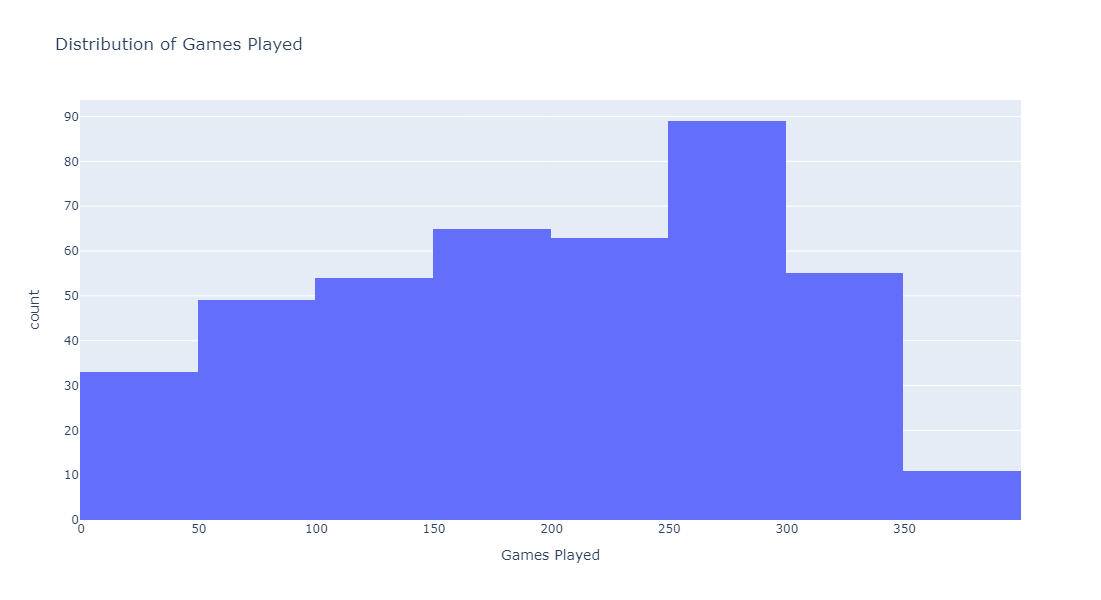

In [9]:
num_bins = math.ceil(1 + math.log2(len(preprocessed_data)))

# Create histogram plot
fig = px.histogram(preprocessed_data, x='GP', nbins=num_bins, 
                   title='Distribution of Games Played',
                   labels={'GP': 'Games Played', 'count': 'Frequency'})

# Update layout
fig.update_layout(width=500, height=600)

# Show the plot
fig.show()

Referring back to the descriptive statistics there's a sizable difference between Min and Max Games Played ('GP'). Additionally, the chart in the cell above shows that games played is skewed.I will create per game stats so that players who play less games can be compared to players who play more games.

In [10]:
#iterate over the column calculating per game stats
per_game_cols = preprocessed_data.columns[-16:]

for col in per_game_cols:
    new_col_name = f'{col}_Per_Game'
    preprocessed_data[new_col_name] = round(preprocessed_data[col] / 
                                            preprocessed_data['GP'],2)

In [11]:
preprocessed_data.head().round()

,Current_Contract,First_Name,Last_Name,PLAYER_ID,GP,GS,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,PF,PTS,GS_Per_Game,MIN_Per_Game,FGM_Per_Game,FGA_Per_Game,FG3M_Per_Game,FG3A_Per_Game,FTM_Per_Game,FTA_Per_Game,OREB_Per_Game,DREB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game
0,51915615.0,stephen,curry,201939,257,257,8774.0,2417,5144,1261,3049,1183,1287,151,1265,1513,311,78,806,543,7278,1.0,34.0,9.0,20.0,5.0,12.0,5.0,5.0,1.0,5.0,6.0,1.0,0.0,3.0,2.0,28.0
1,47649433.0,kevin,durant,201142,184,181,6548.0,1868,3442,386,949,1196,1315,76,1204,1016,141,231,623,381,5318,1.0,36.0,10.0,19.0,2.0,5.0,6.0,7.0,0.0,7.0,6.0,1.0,1.0,3.0,2.0,29.0
2,47607350.0,nikola,jokic,203999,368,368,12126.0,3323,5903,409,1199,1597,1930,972,3220,2953,484,257,1224,1007,8652,1.0,33.0,9.0,16.0,1.0,3.0,4.0,5.0,3.0,9.0,8.0,1.0,1.0,3.0,3.0,24.0
3,47607350.0,joel,embiid,203954,300,300,9825.0,2817,5561,353,1040,2659,3206,673,2796,1089,284,467,984,894,8646,1.0,33.0,9.0,19.0,1.0,3.0,9.0,11.0,2.0,9.0,4.0,1.0,2.0,3.0,3.0,29.0
4,47607350.0,lebron,james,2544,278,277,9795.0,2872,5661,645,1862,1225,1717,280,1972,2212,321,185,1000,491,7614,1.0,35.0,10.0,20.0,2.0,7.0,4.0,6.0,1.0,7.0,8.0,1.0,1.0,4.0,2.0,27.0


Now that we have per game stats, I will drop the aggregated total columns.

In [12]:
totals_col = ['GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 
              'OREB', 'DREB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

regression_df = preprocessed_data.drop(columns= totals_col)

In [13]:
regression_df.head()

,Current_Contract,First_Name,Last_Name,PLAYER_ID,GS_Per_Game,MIN_Per_Game,FGM_Per_Game,FGA_Per_Game,FG3M_Per_Game,FG3A_Per_Game,FTM_Per_Game,FTA_Per_Game,OREB_Per_Game,DREB_Per_Game,AST_Per_Game,STL_Per_Game,BLK_Per_Game,TOV_Per_Game,PF_Per_Game,PTS_Per_Game
0,51915615.0,stephen,curry,201939,1.00,34.14,9.40,20.02,4.91,11.86,4.60,5.01,0.59,4.92,5.89,1.21,0.30,3.14,2.11,28.32
1,47649433.0,kevin,durant,201142,0.98,35.59,10.15,18.71,2.10,5.16,6.50,7.15,0.41,6.54,5.52,0.77,1.26,3.39,2.07,28.90
2,47607350.0,nikola,jokic,203999,1.00,32.95,9.03,16.04,1.11,3.26,4.34,5.24,2.64,8.75,8.02,1.32,0.70,3.33,2.74,23.51
3,47607350.0,joel,embiid,203954,1.00,32.75,9.39,18.54,1.18,3.47,8.86,10.69,2.24,9.32,3.63,0.95,1.56,3.28,2.98,28.82
4,47607350.0,lebron,james,2544,1.00,35.23,10.33,20.36,2.32,6.70,4.41,6.18,1.01,7.09,7.96,1.15,0.67,3.60,1.77,27.39


In [14]:
regression_df['PTS_Per_Game'].describe().round(2)

count    419.00
mean      10.52
std        6.06
min        1.24
25%        5.94
50%        9.01
75%       14.07
max       29.23
Name: PTS_Per_Game, dtype: float64

In related studies, assists, points, and turnovers have impacted contract values, and while my dataset is different from the related studies I am curious to understand how those metric relate to contract values.

In [15]:
#create a new column called 'AST_Rate' that categorizes 'AST_per_game'
conditions = [
    regression_df['AST_Per_Game'].round(2) >= 4.20,
    (regression_df['AST_Per_Game'].round(2) < 4.20) & 
    (regression_df['AST_Per_Game'].round(2) >= 0.44),
    regression_df['AST_Per_Game'].round(2) < 0.44
]
values = ['high', 'medium', 'low']

# Create the 'AST_Rate' column based on the conditions
regression_df['AST_Rate'] = np.select(conditions, values, default=np.nan)

# Create boxplot
fig = px.box(regression_df, x='AST_Rate', y='Current_Contract',
             title='A Comparison of Assist Per Game',
             color ='AST_Rate',
             color_discrete_map={'high': '#064096', 'medium': '#81a6c8', 
                                 'low': '#adc89e'},
            labels={'AST_Rate': 'Assist Rate', 
                     'Current_Contract': 'Contract Value'})

# Update layout
fig.update_layout(width=400, 
                  height=400,
                  xaxis=dict(showgrid=False), 
                  yaxis=dict(showgrid=False))

# Show the plot
fig.show()

In the cell above we can see that players with high assist rates (>4.2 per game) tend to earn more money. This sample does include the entire population so the medium and low rate are representative.

In [16]:
#create a new column called 'TO_Rate' that categorizes 'TOV_per_game'
conditions = [
    regression_df['TOV_Per_Game'].round(2) >= 2.07,
    (regression_df['TOV_Per_Game'].round(2) < 2.07) & 
    (regression_df['TOV_Per_Game'].round(2) >= 0.47),
    regression_df['TOV_Per_Game'].round(2) < 0.47
]
values = ['high', 'medium', 'low']

# Create the 'AST_Rate' column based on the conditions
regression_df['TO_Rate'] = np.select(conditions, values, default=np.nan)

# Create boxplot
fig = px.scatter(regression_df, x='TOV_Per_Game', y='Current_Contract',
             title='Comparison of Distributions by Turnover Rate',
             color ='TO_Rate',
             color_discrete_map={'high': '#064096', 'medium': '#81a6c8', 
                                 'low': '#adc89e'},
             labels={'TO_Rate': 'Turnover Rate', 
                     'Current_Contract': 'Contract Value'})

# Update layout
fig.update_layout(width=500, 
                  height=400,
                  xaxis=dict(showgrid=False), 
                  yaxis=dict(showgrid=False))

# Show the plot
fig.show()

#print the correlation metric
print(regression_df[['TOV_Per_Game','Current_Contract']].corr())


                  TOV_Per_Game  Current_Contract
TOV_Per_Game          1.000000          0.713049
Current_Contract      0.713049          1.000000


The cell above shows a moderately strong positive correlation between turnovers and contract values. This is a case of correlation does not equal causation, because turnovers actually have a negative impact on the game. When a player turns the ball over his teams loses an oppourtunity to score points. In the context on this dataset, players with higher contract values also have higher turnover rates because they usually have the ball more.

In [17]:
#create a new column called 'Score_Rate' that categorizes 'PTS_per_game'
conditions = [
    regression_df['PTS_Per_Game'].round(2) >= 16.58,
    (regression_df['PTS_Per_Game'].round(2) < 16.58) & 
    (regression_df['PTS_Per_Game'].round(2) >= 4.46),
    regression_df['PTS_Per_Game'].round(2) < 4.46
]
values = ['high', 'medium', 'low']

# Create the 'AST_Rate' column based on the conditions
regression_df['Score_Rate'] = np.select(conditions, values, default=np.nan)

# Create boxplot
fig = px.scatter(regression_df, x='PTS_Per_Game', y='Current_Contract',
             title='Comparison of Distributions by Scoring Rate',
             color ='Score_Rate',
             color_discrete_map={'high': '#064096', 'medium': '#81a6c8', 
                                 'low': '#adc89e'},
             labels={'Score_Rate': 'Scoring Rate', 
                     'Current_Contract': 'Current Contract'})

# Update layout
fig.update_layout(width=500, 
                  height=400,
                  xaxis=dict(showgrid=False), 
                  yaxis=dict(showgrid=False))

# Show the plot
fig.show()

#print the correlation metric
print(regression_df[['PTS_Per_Game','Current_Contract']].corr())


                  PTS_Per_Game  Current_Contract
PTS_Per_Game          1.000000          0.841468
Current_Contract      0.841468          1.000000


As expected there is a strong positive correlation between the scoring rate and contract values, in the context of this dataset higher scorers are more valuable because the team with the most points will win the game.

Are there any columns that lack variance necessary to make predictions?

In [18]:
print(regression_df.var(numeric_only= True))

Current_Contract    1.361964e+14
GS_Per_Game         1.243046e-01
MIN_Per_Game        6.168737e+01
FGM_Per_Game        4.611111e+00
FGA_Per_Game        2.027354e+01
FG3M_Per_Game       7.049936e-01
FG3A_Per_Game       4.716682e+00
FTM_Per_Game        1.984625e+00
FTA_Per_Game        2.993166e+00
OREB_Per_Game       5.369617e-01
DREB_Per_Game       2.865559e+00
AST_Per_Game        3.528240e+00
STL_Per_Game        1.260525e-01
BLK_Per_Game        1.543743e-01
TOV_Per_Game        6.398220e-01
PF_Per_Game         3.965185e-01
PTS_Per_Game        3.671359e+01
dtype: float64


### 2. Check Regression Assumptions

Before we conduct regression analysis we need to check that the data set meets the following assumptions:
- Linearity: The relationship between independent and dependent variables is linear
- Independence: The observations are independent of each other

In [19]:
#use a SPLOM chart to visually check for linear relationship
fig = px.scatter_matrix(regression_df,
                        dimensions=['Current_Contract', 'GS_Per_Game', 
                                    'MIN_Per_Game', 'FGM_Per_Game', 
                                    'FGA_Per_Game', 'FG3M_Per_Game', 
                                    'FG3A_Per_Game', 'FTM_Per_Game', 
                                    'FTA_Per_Game', 'OREB_Per_Game', 
                                    'DREB_Per_Game', 'AST_Per_Game', 
                                    'STL_Per_Game', 'BLK_Per_Game', 
                                    'TOV_Per_Game', 'PF_Per_Game',
                                    'PTS_Per_Game'])

# Update layout
fig.update_layout(
    title='SPLOM',
    width=1200,
    height=1200,
    font=dict(size=6)
)
fig.show()

I focused on the top row of the SPLOM chart to visually inspect if a linear relationship exists between Current_Contract and the other variables in the dataset. To confirm I will also print the Pearson correlation coefficient.

In [20]:
#print Pearson's R to validate visual
regression_df.corr(numeric_only=True)['Current_Contract']

Current_Contract    1.000000
GS_Per_Game         0.705001
MIN_Per_Game        0.723979
FGM_Per_Game        0.833019
FGA_Per_Game        0.799279
FG3M_Per_Game       0.508811
FG3A_Per_Game       0.509879
FTM_Per_Game        0.776162
FTA_Per_Game        0.758861
OREB_Per_Game       0.190251
DREB_Per_Game       0.597306
AST_Per_Game        0.618480
STL_Per_Game        0.530077
BLK_Per_Game        0.271679
TOV_Per_Game        0.713049
PF_Per_Game         0.444709
PTS_Per_Game        0.841468
Name: Current_Contract, dtype: float64

While some relationships are stronger than others, each variable has evidence of linearity. Next I will check for correlation.

In [21]:
#use correlation matrix to visualize correlations
correlation_matrix = regression_df.corr(numeric_only= True)

In [22]:
#create heatmap
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.index,
                y=correlation_matrix.columns,
                color_continuous_scale='temps',
                zmin= -1,
                zmax = 1,
                text_auto= True)

# Update layout
fig.update_layout(
    title='Correlation Heatmap',
    width=800,
    height=800
)

# Show plot
fig.show()

The following features have strong correlations to other features in the dataset and will be removed:
- GS_Per_Game
- MIN_Per_Game
- FGA_Per_Game
- FG3A_Per_Game
- FTA_Per_Game
- PTS_Per_Game
- FTM_Per_Game
- TOV_Per_Game

In [23]:
#drop correlated columns
correlated_cols = ['GS_Per_Game', 'MIN_Per_Game','FGA_Per_Game','FG3A_Per_Game',
                   'FTA_Per_Game','PTS_Per_Game','FTM_Per_Game','TOV_Per_Game']

regression_df.drop(columns= correlated_cols, inplace= True)

Re-check correlations

In [24]:
#use correlation matrix to visualize correlations
correlation_matrix = regression_df.corr(numeric_only= True)

#create heatmap
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.index,
                y=correlation_matrix.columns,
                color_continuous_scale='temps',
                zmin= -1,
                zmax = 1,
                text_auto= True)

# Update layout
fig.update_layout(
    title='Correlation Heatmap',
    width=800,
    height=800
)

# Show plot
fig.show()

In [25]:
#save a copy of the final dataframe used for OLS
regression_df.to_csv('../data/regression_df.csv', index = False)

### 3. Regression Analysis

Now, I will use the regression_df to understand how performance metrics impact contract values.

In [26]:
#view the columns
regression_df.columns

Index(['Current_Contract', 'First_Name', 'Last_Name', 'PLAYER_ID',
       'FGM_Per_Game', 'FG3M_Per_Game', 'OREB_Per_Game', 'DREB_Per_Game',
       'AST_Per_Game', 'STL_Per_Game', 'BLK_Per_Game', 'PF_Per_Game',
       'AST_Rate', 'TO_Rate', 'Score_Rate'],
      dtype='object')

In [27]:
#Declare X and y variables
X = regression_df[['FGM_Per_Game', 'FG3M_Per_Game', 'OREB_Per_Game', 
                        'DREB_Per_Game','AST_Per_Game', 'STL_Per_Game', 
                        'BLK_Per_Game', 'PF_Per_Game']]
y = regression_df['Current_Contract']

#Scale to variables to account for the difference in magnitude
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled = pd.concat([X_scaled_df, y], axis=1)

#Fit the OLS regression model using the formula API
formula = 'Current_Contract ~ ' + ' + '.join(df_scaled.columns[:-1])
ols_model = sm.formula.ols(formula=formula, data=df_scaled).fit()

#Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Current_Contract   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     126.2
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          1.46e-105
Time:                        09:20:27   Log-Likelihood:                -7152.1
No. Observations:                 419   AIC:                         1.432e+04
Df Residuals:                     410   BIC:                         1.436e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.105e+07   3.09e+05     35.725

From the output above we can see 4 features have significance (P-value >.05). Let's fit a  model using the significant features only.

In [28]:
#Declare X and y variables
X_final = regression_df[['FGM_Per_Game', 'AST_Per_Game', 'BLK_Per_Game', 
                   'PF_Per_Game']]
y_final = regression_df['Current_Contract']

#Scale to variables to account for the difference in magnitude
scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_final)
X_scaled_df_final = pd.DataFrame(X_scaled_final, columns=X_final.columns)
df_scaled_final = pd.concat([X_scaled_df_final, y_final], axis=1)

#Fit the OLS regression model using the formula API
formula_final = 'Current_Contract ~ ' + ' + '.join(df_scaled_final.columns[:-1])
ols_model_final = sm.formula.ols(formula=formula_final, 
                                 data=df_scaled_final).fit()

#Print the model summary
print(ols_model_final.summary())

                            OLS Regression Results                            
Dep. Variable:       Current_Contract   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     247.5
Date:                Wed, 21 Feb 2024   Prob (F-statistic):          2.40e-108
Time:                        09:20:30   Log-Likelihood:                -7156.4
No. Observations:                 419   AIC:                         1.432e+04
Df Residuals:                     414   BIC:                         1.434e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.105e+07   3.11e+05     35.530   

Interpret Results:
- FGM_Per_Game: Increasing average FGs by 1 adds nearly 9 million dollars to contract value.
- AST_Per_Game: Increasing average assists by 1 adds 1.3 million dollars to contract value.
- BLK_Per_Game: Increasing average blocks by 1 adds 1.2 million dollars to contract value.
- PF_Per_Game: Increasing average fouls by 1 subtracts 9.8 million dollars from contract value.